In [1]:
! unzip ../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip 
! unzip ../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip 
! unzip ../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip 
! unzip ../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip

Archive:  ../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: train.csv               
Archive:  ../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  ../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  ../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
  inflating: test.csv                


In [2]:
! pip install transformers 
# save the best weight ,means less loss valued trained batch 
# do some warm up step initially to make it more effiecient

In [3]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import transformers
from tqdm.notebook import tqdm

In [4]:
bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased") 
bert_model.trainable = False

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-01-24 09:21:39.739930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 09:21:39.740946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 09:21:39.741632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 09:21:39.742668: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
batch_size=32
max_len=128
EPOCHS=2

In [6]:
data=pd.read_csv("./train.csv") 

In [7]:
# count the individual data
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'] 
positive_comment=data[data[label_cols].sum(axis=1)==0]
toxic_comment=data[data[label_cols].sum(axis=1)>0]
no_value=data[data[label_cols].sum(axis=1)=='']

# print(len(positive_comment)) #143346
# print(len(toxic_comment))# 16225
# print(len(no_value))# 16225

# random samling from positve commnet to tkae out of 14000 comment

# toxic_comment=data[data['toxic']==1]
# toxic_comment.shape
## drop some toxic comment for better prediction

# purely toxic
conditions = [
    (toxic_comment['toxic']==1)&
    (toxic_comment['severe_toxic']==0) & (toxic_comment['obscene']==0)&
    (toxic_comment['threat']==0) & (toxic_comment['insult']==0)&
    (toxic_comment['identity_hate']==0)
    ]
purely_toxic=toxic_comment[conditions[0]]
print(purely_toxic.shape)
purely_toxic.sample(frac = 1)
# mixed toxic
mixed_toxic=toxic_comment[toxic_comment['toxic']==1]
print(mixed_toxic.shape)

# drop pure toxic
toxic_comment.drop(purely_toxic.index,inplace=True)

data=pd.concat([
    toxic_comment,
    purely_toxic.sample(n=700),
    positive_comment.sample(n=30_000)
])

data.shape

(5666, 8)
(15294, 8)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(41259, 8)

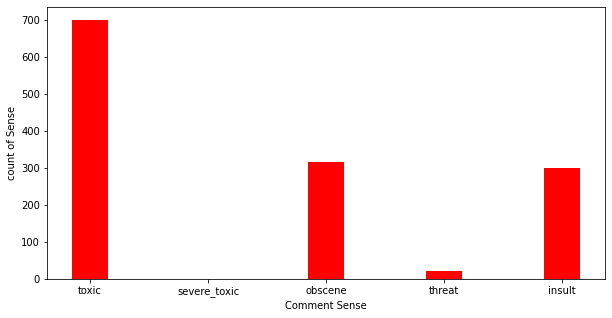

In [8]:
import matplotlib.pyplot as plt
conditions = [
    (data['toxic']==1)&
    (data['severe_toxic']==0) & (data['obscene']==0)&
    (data['threat']==0) & (data['insult']==0)&
    (data['identity_hate']==0)
    ]
toxic_comment=data[conditions[0]]

conditions1 = [
    (data['toxic']==0)&
    (data['severe_toxic']==1) & (data['obscene']==0)&
    (data['threat']==0) & (data['insult']==0)&
    (data['identity_hate']==0)
    ]
severe_toxic_comment=data[conditions1[0]]

conditions2 = [
    (data['toxic']==0)&
    (data['severe_toxic']==0) & (data['obscene']==0)&
    (data['threat']==0) & (data['insult']==1)&
    (data['identity_hate']==0)
    ]
insult_comment=data[conditions2[0]]

conditions3 = [
    (data['toxic']==0)&
    (data['severe_toxic']==0) & (data['obscene']==1)&
    (data['threat']==0) & (data['insult']==0)&
    (data['identity_hate']==0)
    ]
obscene_comment=data[conditions3[0]]

conditions4 = [
    (data['toxic']==0)&
    (data['severe_toxic']==0) & (data['obscene']==0)&
    (data['threat']==1) & (data['insult']==0)&
    (data['identity_hate']==0)
    ]
threat_comment=data[conditions4[0]]


label_bar = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult']
label_data=[toxic_comment.shape[0],severe_toxic_comment.shape[0],obscene_comment.shape[0],threat_comment.shape[0],insult_comment.shape[0]]

fig=plt.figure(figsize=(10,5)) 
plt.bar(label_bar,label_data,color="red",width=0.3)
plt.xlabel("Comment Sense")
plt.ylabel("count of Sense")
plt.show() 

In [9]:
# add up a column positive
conditions = [
    (data['toxic']==0)&
    (data['severe_toxic']==0) & (data['obscene']==0)&
    (data['threat']==0) & (data['insult']==0)&
    (data['identity_hate']==0)
    ]
values = [1]

# data['positive']=np.where(data['toxic']==0 and data['severe_toxic']==0 and  and  and  and ,1,0)
data['positive']=np.select(conditions,values)

label_cols.append("positive")

print(data.shape)
positive_comment=data[data[label_cols].sum(axis=1)==1]
print(len(positive_comment))

(41259, 9)
31394


In [10]:
data["comment_text"]=data["comment_text"].map(lambda x:re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x))

In [11]:
# sense_count_pd=pd.DataFrame(data[label_cols].value_counts()) 
# sense_count_pd

In [12]:
labels =  data[label_cols].values

In [13]:
labels.shape

(41259, 7)

In [14]:
from sklearn.model_selection import train_test_split 
input_sen=data["comment_text"].values
# print(input_sen)
train_inputs,validation_inputs,train_labels,validation_labels=train_test_split(input_sen,labels,random_state=0,test_size=0.1) 


print(train_inputs.shape)
print(train_labels.shape)

print(validation_inputs.shape)
print(validation_labels.shape)
 

(37133,)
(37133, 7)
(4126,)
(4126, 7)


In [15]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence): 
    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
         
        
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=128,
            return_attention_mask=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_tensors="tf",
        )   

        bert_output = bert_model(**encoded)
        
        sequence_output = bert_output.last_hidden_state 
         
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return sequence_output, labels
        else:
            return sequence_output

    def on_epoch_end(self): 
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

In [17]:
train_dataset=BertSemanticDataGenerator(train_inputs,train_labels,shuffle=True)
validation_dataset=BertSemanticDataGenerator(validation_inputs,validation_labels,shuffle=False)

In [18]:
input_layer = tf.keras.layers.Input(shape=(128, 768), name=None)  
flat=tf.keras.layers.Flatten()(input_layer) 
output = tf.keras.layers.Dense(7, activation="softmax")(flat)
model = tf.keras.models.Model(inputs=input_layer, outputs=output)
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 768)]        0         
_________________________________________________________________
flatten (Flatten)            (None, 98304)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 688135    
Total params: 688,135
Trainable params: 688,135
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model.compile()

In [ ]:
# history = model.fit(
#     train_dataset,
#     validation_data=validation_dataset,
#     epochs=2
# )

In [19]:
# custom training loop 
## update at each train step
## reset at the end of each batch

import time
## defining a optimizer 
optimizer= tf.keras.optimizers.Adam(lr=2e-5)

## defining loss function 
loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# ## mean loss define
train_loss=tf.keras.metrics.Mean(name="train_loss")
validation_loss=tf.keras.metrics.Mean(name="validation_loss")

best_validation_loss=tf.keras.metrics.Mean(name="best_validation_loss")

# Metric
## dfining the accuracy metric to track our model accuracy.Here for 6 class we 
## have to declare 2d darray of row 6
train_acc_metric=[tf.keras.metrics.CategoricalAccuracy() for i in range(len(label_cols))]

val_acc_metric=[tf.keras.metrics.CategoricalAccuracy() for i in range(len(label_cols))]

# actually from logits denoting the probability from our custom model layed for each label.It is being fetched before the softmax layer to calculate loss between actual and predicted

batch_size=32
EPOCH=2
train_dataset_size=60000
validation_dataset_size=15000

@tf.function
def train_step(model,x_train,label):
    # Gradiane tape actually records the operation run in forward step
    with tf.GradientTape() as tape:
        #caluculate logits for comparison
        logits_prob=model(x_train,training=True)
        # calculate loss value 
        loss_value=loss_fn(label,logits_prob)
    #calculate gradient of trainable variables against the loss
    gradients=tape.gradient(loss_value,model.trainable_weights)
    # update the gradient according to gradient descent
    optimizer.apply_gradients(zip(gradients,model.trainable_weights))
    # update the mean train ing loss
    train_loss(loss_value)
    # update accuracy metric for each of the 6 classes 
    for i,auc in enumerate(train_acc_metric):
        auc.update_state(label[:,i],logits_prob[:,i])
    return loss_value

@tf.function
def validation_step(model,x_validation,label):
    with tf.GradientTape() as tape:
        validation_logit_prob=model(x_validation,training=False)
        valid_loss=loss_fn(label,validation_logit_prob)
        validation_loss(valid_loss)
        for i,auc in enumerate(val_acc_metric):
            auc.update_state(label[:,i],validation_logit_prob[:,i]) 

def train_model(model,train_dataset,validation_dataset):
    for epoch in range(EPOCHS):
        print('\n Epoch No %d\n' % (epoch,))

        ### training part ###
        for step,(x_batch_train,labels) in enumerate(tqdm(train_dataset)):
            training_loss=train_step(model,x_batch_train,labels)
            
            #log result at every 200 batches
            if step%200==0:
                print(f'\nTrain Step: {epoch}, Loss: {train_loss.result()}')
#                 print("Trainng loss at %d batch of data: %.4f"%(step,float(training_loss)))
                # training accuracy metric at end
                for i, label_name in enumerate(label_cols):
                    print(f"{label_name} roc_auc {train_acc_metric[i].result()}")
                    # reset the accuracy metric after every epoch
                    train_acc_metric[i].reset_states()
            
#         training_accuracy=train_acc_metric.result()
#         print("\nTraining accuracy after %d epoch : %.4f"%(epoch,training_accuracy))
#         train_acc_metric.reset_states()
        
        
        ### validation part ###
        for step,(x_batch_val,labels) in enumerate(tqdm(validation_dataset)):
            validation_step(model,x_batch_val,labels)
        print(f'\n Validation Step: {epoch}, Loss: {validation_loss.result()}')
        ## save best validate model weight
#         if best_validation_loss<validation_loss:
#             best_validation_loss=validation_loss
#             model.save_weights('/kaggle/working/my_checkpoint')
        for i, label_name in enumerate(label_cols):
            print(f"{label_name} roc_auc {val_acc_metric[i].result()}") 
            val_acc_metric[i].reset_states()
#         validation_acc=val_acc_metric.result()
#         val_acc_metric.reset_states()
#         print("\n validation accuracy : %4.f"%(validation_acc))

train_model(model,train_dataset,validation_dataset)
model.save("my_custom_train_model.h5")


 Epoch No 0



/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


  0%|          | 0/1160 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentrop


Train Step: 0, Loss: 2.885316848754883
toxic roc_auc 0.0
severe_toxic roc_auc 0.0
obscene roc_auc 0.0
threat roc_auc 0.0
insult roc_auc 0.0
identity_hate roc_auc 0.0
positive roc_auc 0.0

Train Step: 0, Loss: 1.9412648677825928
toxic roc_auc 0.09000000357627869
severe_toxic roc_auc 0.03999999910593033
obscene roc_auc 0.125
threat roc_auc 0.004999999888241291
insult roc_auc 0.10999999940395355
identity_hate roc_auc 0.06499999761581421
positive roc_auc 0.05000000074505806

Train Step: 0, Loss: 2.1594204902648926
toxic roc_auc 0.10999999940395355
severe_toxic roc_auc 0.07500000298023224
obscene roc_auc 0.10000000149011612
threat roc_auc 0.03500000014901161
insult roc_auc 0.125
identity_hate roc_auc 0.054999999701976776
positive roc_auc 0.04500000178813934

Train Step: 0, Loss: 2.4766838550567627
toxic roc_auc 0.11500000208616257
severe_toxic roc_auc 0.07000000029802322
obscene roc_auc 0.13500000536441803
threat roc_auc 0.04500000178813934
insult roc_auc 0.11999999731779099
identity_hate 

  0%|          | 0/128 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



 Validation Step: 0, Loss: 6.057161808013916
toxic roc_auc 0.0546875
severe_toxic roc_auc 0.0625
obscene roc_auc 0.1328125
threat roc_auc 0.03125
insult roc_auc 0.1953125
identity_hate roc_auc 0.0234375
positive roc_auc 0.0234375

 Epoch No 1



  0%|          | 0/1160 [00:00<?, ?it/s]


Train Step: 1, Loss: 3.288447856903076
toxic roc_auc 0.09375
severe_toxic roc_auc 0.06875000149011612
obscene roc_auc 0.14374999701976776
threat roc_auc 0.03750000149011612
insult roc_auc 0.11249999701976776
identity_hate roc_auc 0.05000000074505806
positive roc_auc 0.03750000149011612

Train Step: 1, Loss: 3.7563154697418213
toxic roc_auc 0.10999999940395355
severe_toxic roc_auc 0.054999999701976776
obscene roc_auc 0.18000000715255737
threat roc_auc 0.09000000357627869
insult roc_auc 0.11500000208616257
identity_hate roc_auc 0.02500000037252903
positive roc_auc 0.05000000074505806

Train Step: 1, Loss: 4.185359477996826
toxic roc_auc 0.10000000149011612
severe_toxic roc_auc 0.07500000298023224
obscene roc_auc 0.125
threat roc_auc 0.33000001311302185
insult roc_auc 0.13500000536441803
identity_hate roc_auc 0.05000000074505806
positive roc_auc 0.06499999761581421

Train Step: 1, Loss: 4.623937606811523
toxic roc_auc 0.125
severe_toxic roc_auc 0.07500000298023224
obscene roc_auc 0.15999

  0%|          | 0/128 [00:00<?, ?it/s]


 Validation Step: 1, Loss: 8.686864852905273
toxic roc_auc 0.0703125
severe_toxic roc_auc 0.046875
obscene roc_auc 0.125
threat roc_auc 0.6953125
insult roc_auc 0.15625
identity_hate roc_auc 0.0234375
positive roc_auc 0.2265625


In [ ]:
# from keras.models import load_model
# model=load_model('../input/mymodel/my_model.h5')

In [41]:
s4 = '''Your code looks like it's undecided about whether it's data or elementdata. I've assumed it's simply a typo.'''
s5="In hindsight, I do apologize for my previous statement."
s6="you are a bitch."
sentence_pairs = np.array([s4])
test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

pro=model.predict(test_data) 
print(np.asarray(pro))
print(label_cols[np.argmax(pro)])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[[2.5708766e-10 0.0000000e+00 9.7222778e-11 0.0000000e+00 4.9823506e-11
  3.1435211e-38 1.0000000e+00]]
positive


In [ ]:
# loading the pre-defined bert model weights
# bert_model.Trainable=True

# train_dataset=BertSemanticDataGenerator(train_inputs,train_labels,shuffle=True)
# validation_dataset=BertSemanticDataGenerator(validation_inputs,validation_labels,shuffle=False)

# trained_history = model.fit(
#     train_dataset,
#     validation_data=validation_dataset,
#     epochs=2
# )

In [42]:
submission_df=pd.read_csv("./sample_submission.csv",index_col='id')
test_df=pd.read_csv("./test.csv")
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','positive']
conditions = [
    (submission_df['toxic']==0.5)&
    (submission_df['severe_toxic']==0.5) & (submission_df['obscene']==0.5)&
    (submission_df['threat']==0.5) & (submission_df['insult']==0.5)&
    (submission_df['identity_hate']==0.5)
    ]
values = [0.5] 
submission_df['positive']=np.select(conditions,values)

print(submission_df.head())
print(test_df.head())


test_bert_op=BertSemanticDataGenerator(test_df['comment_text'],None,include_targets=False,shuffle=True)
submission_df

                  toxic  severe_toxic  obscene  threat  insult  identity_hate  \
id                                                                              
00001cee341fdb12    0.5           0.5      0.5     0.5     0.5            0.5   
0000247867823ef7    0.5           0.5      0.5     0.5     0.5            0.5   
00013b17ad220c46    0.5           0.5      0.5     0.5     0.5            0.5   
00017563c3f7919a    0.5           0.5      0.5     0.5     0.5            0.5   
00017695ad8997eb    0.5           0.5      0.5     0.5     0.5            0.5   

                  positive  
id                          
00001cee341fdb12       0.5  
0000247867823ef7       0.5  
00013b17ad220c46       0.5  
00017563c3f7919a       0.5  
00017695ad8997eb       0.5  
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220

,toxic,severe_toxic,obscene,threat,insult,identity_hate,positive
id,,,,,,,
00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5,0.5
0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5,0.5
00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5,0.5
00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5,0.5
00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5,0.5
fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [43]:
for i,sen in enumerate(tqdm(test_bert_op)):
    sample_ids = test_df.iloc[i*32:(i+1)*32]['id'] 
    pred=model.predict(sen)
    submission_df.loc[sample_ids, label_cols] = pred 

  0%|          | 0/4786 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [44]:
submission_df.to_csv('submission.csv')

In [ ]:
# sample_ids = test_df.iloc[0*32:(0+1)*32]['id'] 
# print(sample_ids)
# submission_df.loc[sample_ids]

In [ ]:
# len(bert_op)

In [ ]:
# # creating batched dataset
# epochs=2
# def create_batch_dataset(data,epochs=epochs,batch_size=batch_size,buffer_size=1000,train=True):
#     dataset=tf.data.Dataset.from_tensor_slices(data)
# #     print(dataset.as_numpy_iterator())
#     if train:
#         dataset=dataset.shuffle(buffer_size=buffer_size)
#         # uses for shuffling the dataset.Select the first buffer_size element from dataset
#     dataset=dataset.repeat(epochs)
#     # just repeat the whole dataset
#     dataset=dataset.batch(batch_size=batch_size)
#     # devide the whole dataset into batch size and create an array of array
#     if train:
#         dataset=dataset.prefetch(1)
#     #     It has no concept of examples vs. batches. examples.prefetch(2) will prefetch two 
#     # elements (2 examples), while examples.batch(20).prefetch(2) will prefetch 2 elements (2 
#     # batches, of 20 examples each).
#     return dataset
# train_dataset=create_batch_dataset((train_inputs,train_masks,train_labels),train=True)
# validation_dataset=create_batch_dataset((validation_inputs,validation_masks,validation_labels),train=True)

In [ ]:
# https://www.kaggle.com/nkaenzig/bert-tensorflow-2-huggingface-transformers
# https://www.kaggle.com/satyamkryadav/bert-model-96-77/notebook
# https://github.com/tensorflow/models/blob/master/official/nlp/docs/tfhub.md